# San Francisco Renting Prices Regression Project

## Importing packages and data

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import StandardScaler

from My_ML_Functions import reg_cross_validate_model, reg_cross_validate_model_ridge, plot_diagnostics

rentals_df = pd.read_csv("sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


In [3]:
rentals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,989.0,3595.035389,1546.222670,750.0,2650.0,3300.0,4242.0,19000.0
sqft,989.0,976.765420,474.629798,150.0,650.0,900.0,1200.0,3500.0
beds,989.0,1.679474,1.076710,0.0,1.0,2.0,2.0,6.0
bath,989.0,1.390293,0.562714,1.0,1.0,1.0,2.0,4.0
hood_district,989.0,7.052578,2.404716,1.0,6.0,8.0,9.0,10.0


## Additional Data Transformations

In [4]:
# Although hood_district seems to be a numeric columns, it is in fact a categorical one.
rentals_df['hood_district'] = rentals_df['hood_district'].astype('int').astype('object')
rentals_df['beds'] = rentals_df['beds'].astype('int')
rentals_df['bath'] = rentals_df['bath'].astype('int')

## EDA

### Target

In [5]:
print("Descriptive statistics for the target variable:")
print(rentals_df['price'].describe())

Descriptive statistics for the target variable:
count      989.000000
mean      3595.035389
std       1546.222670
min        750.000000
25%       2650.000000
50%       3300.000000
75%       4242.000000
max      19000.000000
Name: price, dtype: float64


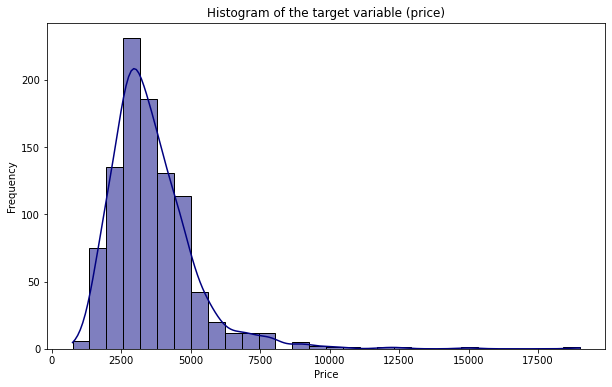

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(rentals_df['price'], bins=30, kde=True, color='navy')
plt.title("Histogram of the target variable (price)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

Both quartile calculation and histogram show existance of outliers in the dataset.

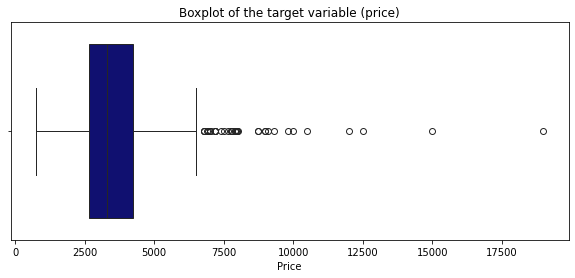

In [7]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=rentals_df['price'], color='navy')
plt.title("Boxplot of the target variable (price)")
plt.xlabel("Price")
plt.show()

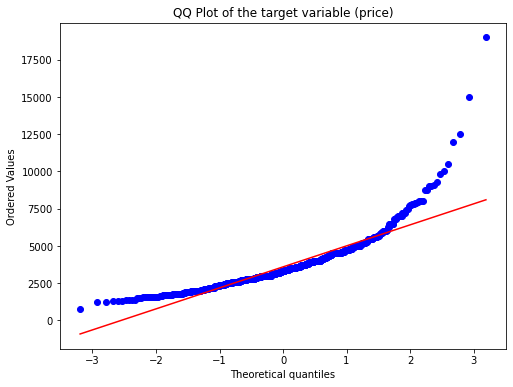

In [8]:
plt.figure(figsize=(8, 6))
stats.probplot(rentals_df['price'], dist="norm", plot=plt)
plt.title("QQ Plot of the target variable (price)")
plt.show()

In [9]:
shapiro_stat, p_value = stats.shapiro(rentals_df['price'])

print("Shapiro-Wilk test statistic:", shapiro_stat)
print("Shapiro-Wilk p-value:", p_value)

Shapiro-Wilk test statistic: 0.831337407916176
Shapiro-Wilk p-value: 4.811954701053989e-31


The Shapiro-Wilk test returned a p-value of 0.000 (p < 0.05), leading to rejection of the null hypothesis of normality. This indicates that the 'price' variable is not normally distributed, and a transformation (e.g., logarithmic) might be considered.

### Indepenent variables

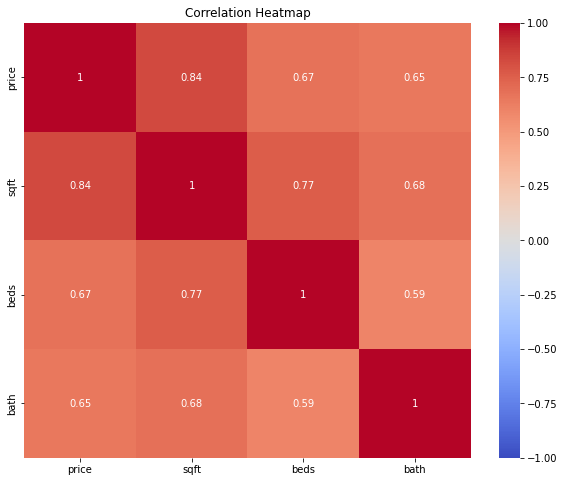

In [10]:
correlation_matrix = rentals_df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))

sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
);

plt.title('Correlation Heatmap')
plt.show()

All numeric variables are correlated with the target, but also with each other. That may lead to colinearity issues.

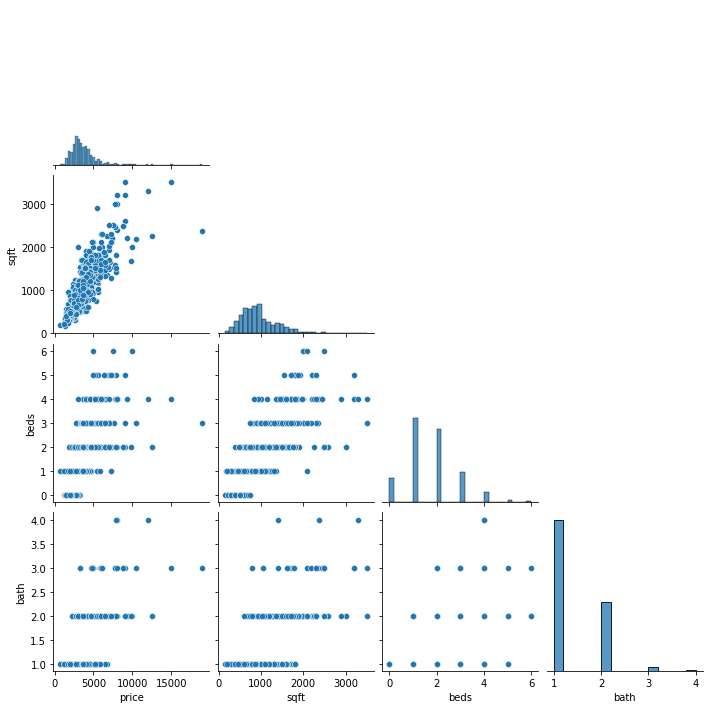

In [11]:
sns.pairplot(rentals_df[['price', 'sqft', 'beds', 'bath']], corner=True)
plt.show()

There is a clear relationship between price and square footage, which seems to be linear for the most of data points. Same apply to number of bedrooms and bathrooms.
Intrestingly, the most expensive apartment has not six, but only three bathrooms.

In [12]:
categorical_columns = rentals_df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"Value counts for '{col}':")
    print(rentals_df[col].value_counts())
    print("\n")

Value counts for 'laundry':
laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64


Value counts for 'pets':
pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64


Value counts for 'housing_type':
housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64


Value counts for 'parking':
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64


Value counts for 'hood_district':
hood_district
9     332
8     207
7     123
5     106
6      62
2      51
1      50
10     33
3      14
4      11
Name: count, dtype: int64




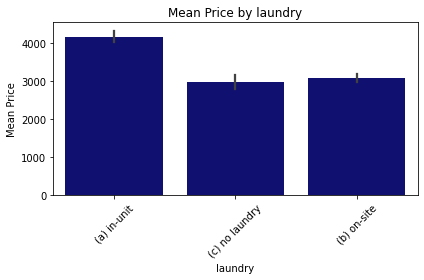

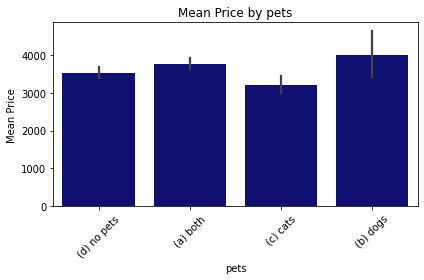

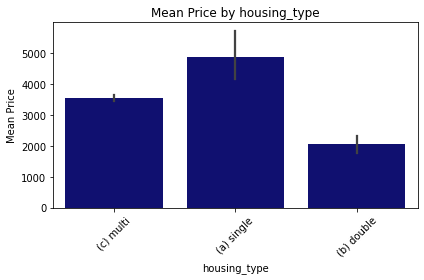

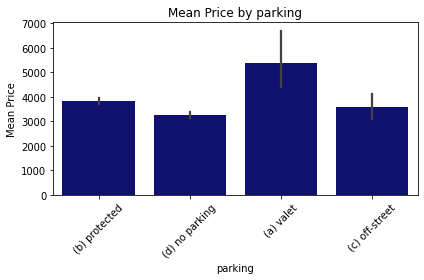

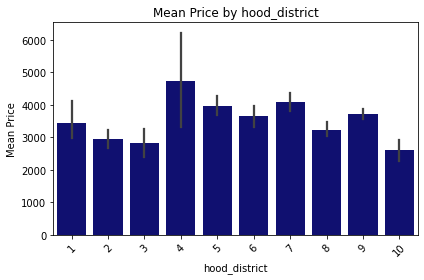

In [13]:
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=col, y='price', data=rentals_df, estimator=np.mean, color='navy')
    plt.title(f'Mean Price by {col}')
    plt.xlabel(col)
    plt.ylabel('Mean Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Based on the value_counts and barplots analysis, the following insights were obtained:

Laundry: There is no significant price difference between properties with communal laundry facilities and those without any access. Consequently, these two categories will be combined.<br>
Pets: Properties that allow only dogs are the most expensive, although they are very few in the dataset. Typically, if owners allow dogs, they also permit cats, so the "dogs" and "both" options will be merged.<br>
Housing Type: Although the "single" and "double" variants are rare, their impact on price is significant enough that no grouping will be performed for these variants.<br>
Parking: Apartments with valet parking are clearly the most expensive, while those without any parking are the cheapest. The two intermediate parking options will be grouped together.<br>
Hood District: Neighborhoods will be grouped based on their location and intended use, with expert knowledge on the purpose of individual districts informing this grouping.

## Feature Engineering


In [14]:
laundry_mapping = {
    '(a) in-unit': 'in-unit',
    '(b) on-site': 'not-in-unit',
    '(c) no laundry': 'not-in-unit'
}

pets_mapping = {
    '(d) no pets': 'no pets',
    '(a) both': 'dogs & cats',
    '(b) dogs': 'dogs & cats',
    '(c) cats': 'cats'
}

parking_mapping = {
    '(a) valet': 'valet',
    '(d) no parking': 'no parking',
    '(b) protected': 'protected/off-street',
    '(c) off-street': 'protected/off-street'
}

housing_type_mapping = {
    '(c) multi': 'multi',
    '(a) single': 'single',
    '(b) double': 'double' 
}

hood_mapping = {
    1: 'North',
    2: 'West',
    3: 'West',
    4: 'Central',
    5: 'Central',
    6: 'Central',
    7: 'North',
    8: 'North',
    9: 'Central',
    10: 'South',
    11: 'South'
}

rentals_df['laundry'] = rentals_df['laundry'].map(laundry_mapping)
rentals_df['pets'] = rentals_df['pets'].map(pets_mapping)
rentals_df['parking'] = rentals_df['parking'].map(parking_mapping)
rentals_df['housing_type'] = rentals_df['housing_type'].map(housing_type_mapping)
rentals_df['hood_district'] = rentals_df['hood_district'].map(hood_mapping)

In [15]:
rentals_df = pd.get_dummies(rentals_df, drop_first=True, dtype=int)

In [16]:
rentals_df.head()

,price,sqft,beds,bath,laundry_not-in-unit,pets_dogs & cats,pets_no pets,housing_type_multi,housing_type_single,parking_protected/off-street,parking_valet,hood_district_North,hood_district_South,hood_district_West
0,6800,1600.0,2,2,0,0,1,1,0,1,0,1,0,0
1,3500,550.0,1,1,0,1,0,1,0,1,0,1,0,0
2,5100,1300.0,2,1,0,1,0,1,0,0,0,1,0,0
3,9000,3500.0,3,2,0,0,1,1,0,1,0,1,0,0
4,3100,561.0,1,1,1,1,0,1,0,0,0,1,0,0


## Model Fitting & Validation Scoring

This file contains two models:
- The initial, baseline model.
- The final model, which was determined to be the best.

The thought process, data transformations, and all intermediate models are documented and developed in a separate notebook.

In [17]:
X = sm.add_constant(rentals_df.drop('price', axis=1))
y = rentals_df['price']

## Initial model

In [18]:
initial_model = reg_cross_validate_model(X, y, 5)

Fold 1:
  Training -> R²: 0.751, MAE: 494.555, RMSE: 783.776
  Test     -> R²: 0.777, MAE: 469.374, RMSE: 682.064
--------------------------------------------------
Fold 2:
  Training -> R²: 0.763, MAE: 493.070, RMSE: 791.288
  Test     -> R²: 0.691, MAE: 476.492, RMSE: 651.161
--------------------------------------------------
Fold 3:
  Training -> R²: 0.736, MAE: 484.304, RMSE: 771.993
  Test     -> R²: 0.813, MAE: 486.089, RMSE: 736.393
--------------------------------------------------
Fold 4:
  Training -> R²: 0.747, MAE: 485.219, RMSE: 778.119
  Test     -> R²: 0.786, MAE: 490.710, RMSE: 710.563
--------------------------------------------------
Fold 5:
  Training -> R²: 0.792, MAE: 463.282, RMSE: 675.028
  Test     -> R²: 0.644, MAE: 535.963, RMSE: 1064.010
--------------------------------------------------
Summary of Cross-Validation Metrics:
Average Training R²: 0.758 ± 0.019
Average Training MAE: 484.086 ± 11.175
Average Training RMSE: 760.041 ± 42.980

Average Test R²: 0.742

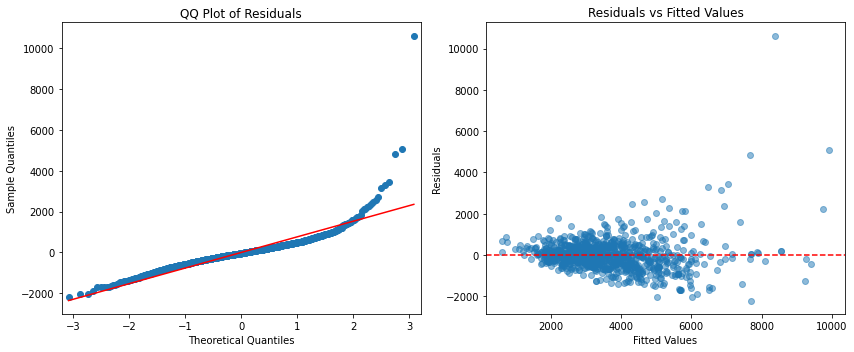

In [19]:
plot_diagnostics(initial_model)

Comment: Based on the diagnostic plots and tests, there is evidence of heteroskedasticity in the model. To address this issue and stabilize the variance of the errors, it is advisable to apply a logarithmic transformation to the target variable (price). This transformation can help meet the homoscedasticity assumption, leading to more reliable and interpretable model estimates.

## Intermediate models

In [20]:
y = np.log(y)

In [21]:
model1 = reg_cross_validate_model(X, y, 5)

Fold 1:
  Training -> R²: 0.808, MAE: 0.132, RMSE: 0.169
  Test     -> R²: 0.780, MAE: 0.124, RMSE: 0.159
--------------------------------------------------
Fold 2:
  Training -> R²: 0.818, MAE: 0.129, RMSE: 0.165
  Test     -> R²: 0.717, MAE: 0.136, RMSE: 0.175
--------------------------------------------------
Fold 3:
  Training -> R²: 0.790, MAE: 0.131, RMSE: 0.167
  Test     -> R²: 0.838, MAE: 0.130, RMSE: 0.171
--------------------------------------------------
Fold 4:
  Training -> R²: 0.798, MAE: 0.129, RMSE: 0.167
  Test     -> R²: 0.823, MAE: 0.132, RMSE: 0.167
--------------------------------------------------
Fold 5:
  Training -> R²: 0.809, MAE: 0.128, RMSE: 0.164
  Test     -> R²: 0.781, MAE: 0.138, RMSE: 0.178
--------------------------------------------------
Summary of Cross-Validation Metrics:
Average Training R²: 0.805 ± 0.010
Average Training MAE: 0.130 ± 0.001
Average Training RMSE: 0.166 ± 0.002

Average Test R²: 0.788 ± 0.042
Average Test MAE: 0.132 ± 0.005
Averag

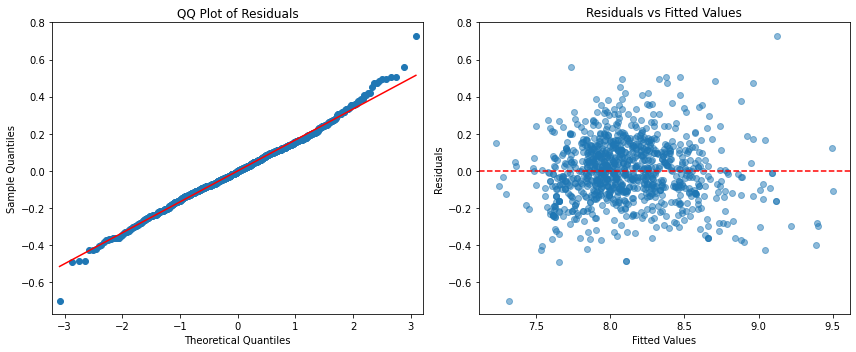

In [22]:
plot_diagnostics(model1)

After log-transforming the target variable, the model not only exhibited an increase in R² but also the residuals now conform to the normality assumption.
Although the variable "hood_district_North" has the biggest p-value, the other variants of this dummy variable are significant, so it is better to drop the variable related to pets. 

In [23]:
X = X.drop(['pets_dogs & cats', 'pets_no pets'], axis = 1)

In [24]:
model2 = reg_cross_validate_model(X, y, 5)

Fold 1:
  Training -> R²: 0.808, MAE: 0.132, RMSE: 0.169
  Test     -> R²: 0.779, MAE: 0.125, RMSE: 0.160
--------------------------------------------------
Fold 2:
  Training -> R²: 0.817, MAE: 0.130, RMSE: 0.166
  Test     -> R²: 0.722, MAE: 0.136, RMSE: 0.173
--------------------------------------------------
Fold 3:
  Training -> R²: 0.790, MAE: 0.131, RMSE: 0.167
  Test     -> R²: 0.838, MAE: 0.131, RMSE: 0.172
--------------------------------------------------
Fold 4:
  Training -> R²: 0.797, MAE: 0.130, RMSE: 0.167
  Test     -> R²: 0.823, MAE: 0.133, RMSE: 0.168
--------------------------------------------------
Fold 5:
  Training -> R²: 0.808, MAE: 0.129, RMSE: 0.164
  Test     -> R²: 0.780, MAE: 0.139, RMSE: 0.178
--------------------------------------------------
Summary of Cross-Validation Metrics:
Average Training R²: 0.804 ± 0.010
Average Training MAE: 0.130 ± 0.001
Average Training RMSE: 0.167 ± 0.002

Average Test R²: 0.788 ± 0.040
Average Test MAE: 0.132 ± 0.005
Averag

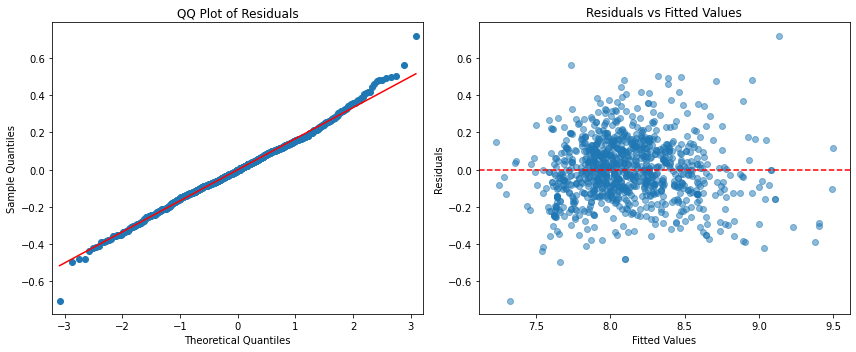

In [25]:
plot_diagnostics(model2)

The R2 improved and residuals assumptions are met. However, there is probably some problem with multicolinearity, which is worth examining.

In [26]:
pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                           99.754059
sqft                             3.265722
beds                             2.635509
bath                             2.024389
laundry_not-in-unit              1.326933
housing_type_multi               4.588157
housing_type_single              4.477652
parking_protected/off-street     1.175604
parking_valet                    1.139933
hood_district_North              1.201187
hood_district_South              1.064085
hood_district_West               1.277070
dtype: float64

The R² has improved and the residual assumptions are satisfied. However, there may still be some multicollinearity issues that merit further examination.

In [27]:
X['bedrooms_to_bathrooms_ratio'] = X['beds'] / X['bath']

In [28]:
model3 = reg_cross_validate_model(X, y, 5)

Fold 1:
  Training -> R²: 0.815, MAE: 0.130, RMSE: 0.166
  Test     -> R²: 0.788, MAE: 0.124, RMSE: 0.156
--------------------------------------------------
Fold 2:
  Training -> R²: 0.825, MAE: 0.127, RMSE: 0.162
  Test     -> R²: 0.726, MAE: 0.136, RMSE: 0.172
--------------------------------------------------
Fold 3:
  Training -> R²: 0.797, MAE: 0.129, RMSE: 0.163
  Test     -> R²: 0.844, MAE: 0.128, RMSE: 0.168
--------------------------------------------------
Fold 4:
  Training -> R²: 0.805, MAE: 0.128, RMSE: 0.164
  Test     -> R²: 0.830, MAE: 0.131, RMSE: 0.164
--------------------------------------------------
Fold 5:
  Training -> R²: 0.814, MAE: 0.127, RMSE: 0.162
  Test     -> R²: 0.793, MAE: 0.135, RMSE: 0.173
--------------------------------------------------
Summary of Cross-Validation Metrics:
Average Training R²: 0.811 ± 0.010
Average Training MAE: 0.128 ± 0.001
Average Training RMSE: 0.163 ± 0.001

Average Test R²: 0.796 ± 0.041
Average Test MAE: 0.131 ± 0.004
Averag

In [29]:
pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                           136.317057
sqft                              3.265843
beds                             21.261796
bath                              8.964555
laundry_not-in-unit               1.335259
housing_type_multi                4.588310
housing_type_single               4.482050
parking_protected/off-street      1.176809
parking_valet                     1.149292
hood_district_North               1.201876
hood_district_South               1.064358
hood_district_West                1.277088
bedrooms_to_bathrooms_ratio      12.952082
dtype: float64

In [30]:
X = X.drop('beds', axis=1)

In [31]:
model4 = reg_cross_validate_model(X, y, 5) 

Fold 1:
  Training -> R²: 0.815, MAE: 0.130, RMSE: 0.166
  Test     -> R²: 0.788, MAE: 0.124, RMSE: 0.156
--------------------------------------------------
Fold 2:
  Training -> R²: 0.825, MAE: 0.127, RMSE: 0.162
  Test     -> R²: 0.725, MAE: 0.136, RMSE: 0.172
--------------------------------------------------
Fold 3:
  Training -> R²: 0.797, MAE: 0.129, RMSE: 0.164
  Test     -> R²: 0.844, MAE: 0.128, RMSE: 0.168
--------------------------------------------------
Fold 4:
  Training -> R²: 0.805, MAE: 0.128, RMSE: 0.164
  Test     -> R²: 0.830, MAE: 0.130, RMSE: 0.164
--------------------------------------------------
Fold 5:
  Training -> R²: 0.814, MAE: 0.127, RMSE: 0.162
  Test     -> R²: 0.793, MAE: 0.135, RMSE: 0.173
--------------------------------------------------
Summary of Cross-Validation Metrics:
Average Training R²: 0.811 ± 0.010
Average Training MAE: 0.128 ± 0.001
Average Training RMSE: 0.164 ± 0.001

Average Test R²: 0.796 ± 0.041
Average Test MAE: 0.131 ± 0.005
Averag

It appears that the ratio of bedrooms to bathrooms is more influential than the absolute number of bedrooms.

In [32]:
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X, y)

Ridge(random_state=42)

In [33]:
model5 = reg_cross_validate_model_ridge(X, y, alpha=1.0, n_splits=5)

Fold 1:
  Training -> R²: 0.815, MAE: 0.130, RMSE: 0.166
  Test     -> R²: 0.789, MAE: 0.123, RMSE: 0.156
--------------------------------------------------
Fold 2:
  Training -> R²: 0.825, MAE: 0.127, RMSE: 0.162
  Test     -> R²: 0.727, MAE: 0.135, RMSE: 0.172
--------------------------------------------------
Fold 3:
  Training -> R²: 0.797, MAE: 0.129, RMSE: 0.164
  Test     -> R²: 0.843, MAE: 0.128, RMSE: 0.169
--------------------------------------------------
Fold 4:
  Training -> R²: 0.805, MAE: 0.128, RMSE: 0.164
  Test     -> R²: 0.830, MAE: 0.131, RMSE: 0.164
--------------------------------------------------
Fold 5:
  Training -> R²: 0.814, MAE: 0.127, RMSE: 0.162
  Test     -> R²: 0.793, MAE: 0.135, RMSE: 0.173
--------------------------------------------------
Summary of Cross-Validation Metrics:
Average Training R²: 0.811 ± 0.010
Average Training MAE: 0.128 ± 0.001
Average Training RMSE: 0.164 ± 0.001

Average Test R²: 0.796 ± 0.040
Average Test MAE: 0.131 ± 0.004
Averag